In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", 100)

In [3]:
comments_path = 'data/comments_-33041211.pkl'
users_path = 'data/users_-33041211.pkl'

In [4]:
with open(comments_path, 'rb') as f:
    comments = pickle.load(f)
with open(users_path, 'rb') as f:
    users = pickle.load(f)

In [5]:
comments_df = pd.DataFrame(comments)

In [8]:
comments_df.head()

,attachments,comment_id,date,from_id,likes,owner_id,reply_to_cid,reply_to_uid,text
0,None,3804948,1506161801,395223136,66,-33041211,None,None,"Тюремное погоняло будет ""Нос"""
1,None,3804951,1506161835,214650517,108,-33041211,None,None,Слишком типичный портрет для воронежа
2,None,3804953,1506161881,176737939,185,-33041211,None,None,Тут пол города с такой рожей ходят.
3,None,3804956,1506161962,21542049,7,-33041211,None,None,Я его около цирка уродов видел... Мутный тип
4,None,3804961,1506162137,62058251,8,-33041211,None,None,"[id395223136|Король], шнобель"


In [9]:
comments_df.from_id.nunique() # was 138796

155784

In [10]:
comments_df.shape # 2637605

(2969507, 9)

# Preparing data

In [11]:
def university_cond(user):
    return len(user.get('universities', [])) == 1

In [12]:
def faculty_cond(user):
    return user['universities'][0].get('faculty_name') is not None

In [13]:
users_with_univ = list(filter(university_cond, users))
users_with_fac = list(filter(faculty_cond, users_with_univ))

In [14]:
len(users_with_univ), len(users_with_fac)

(15588, 11879)

In [15]:
users_with_fac[3]

{'activities': 'Профессиональное ничегонеделание, завершение гештальта',
 'bdate': '20.1.1995',
 'books': 'Детективы в стиле "Нуар", научная фантастика: братья Стругацкие, Лем, серия Метро:2033 (некоторые).\nРемарк.',
 'can_see_all_posts': 0,
 'can_see_audio': 1,
 'can_write_private_message': 1,
 'first_name': 'Dmitry',
 'id': 45613142,
 'interests': 'История ХХ-го века, политология, философия, психология, фурри',
 'last_name': 'Liberman',
 'movies': 'It\'s a Wonderful Life, Felidae(1994 г.в.), Godfather I, II, III; Scarface, Le Professionel;Ice Age (1, 2, 3), Брат, Брат 2, В джазе только девушки, Луна 2112, Всегда говори "Да", Молодые львы, Спасти рядового Райана, Список Шиндлера, Balada triste de trompeta, Шестиструнный самурай, Навсикая из Долины Ветров, Небесный замок Лапута, Унесенные призраками',
 'music': 'Elvis 4ever, fuck yeah! Modern Talking, Smokie, The Baseballs, Наутилус Помпилиус, Кино, Машина времени, Крематорий, АлисА, Кипелов, группа "Ростов", Deep Purple, Bob Marley, 

In [16]:
users_ = []
for u in users_with_fac:
    u.pop('occupation', None)
    u.pop('relation_partner', None)
    try:
        univ = u.pop('universities')[0]
    except:
        univ = None
    u.update({'univ_name': univ['name'], 'faculty_name': univ['faculty_name'],
              'education_form': univ.get('education_form'), 'education_status': univ.get('education_status'),
              'graduation': univ.get('graduation')})
    
    pers = u.pop('personal', None)
    if pers:
        u.update({'political': pers.get('political'), 'langs': ','.join(pers.get('langs', [])),
                  'religion': pers.get('religion'), 'inspired_by': pers.get('inspired_by'),
                  'people_main': pers.get('people_main'), 'life_main': pers.get('life_main'),
                  'smoking': pers.get('smoking'), 'alcohol': pers.get('alcohol')})
    users_.append(u)

In [17]:
users_[0]

{'activities': '',
 'alcohol': 4,
 'bdate': '19.5',
 'books': '',
 'can_see_all_posts': 0,
 'can_see_audio': 0,
 'can_write_private_message': 1,
 'education_form': 'Full-time',
 'education_status': 'Student (Specialist)',
 'faculty_name': 'Архитектурный',
 'first_name': 'Maxim',
 'graduation': 2013,
 'id': 3932177,
 'inspired_by': 'Близкие люди',
 'interests': '',
 'langs': 'Русский,English',
 'last_name': 'Smirnov',
 'life_main': 6,
 'movies': '',
 'music': '',
 'people_main': 2,
 'political': 3,
 'relation': 1,
 'religion': 'Православие',
 'sex': 2,
 'smoking': 4,
 'status': '',
 'univ_name': 'Воронежский ГАСУ'}

In [18]:
users_df = pd.DataFrame(users_)

In [27]:
with open('meta_data/vrn_fac_raw.txt', 'w') as f:
    f.writelines('\n'.join(users_df.faculty_name.value_counts()[(users_df.faculty_name.value_counts() > 4)].keys().values))

In [21]:
(users_df.faculty_name.value_counts() > 4).sum()

161

In [26]:
users_df.faculty_name.value_counts()[(users_df.faculty_name.value_counts() > 4)].values.sum()

10325

In [32]:
ing, gum, other = [], [], []
with open('meta_data/vrn_fac.txt', 'r') as f:
    for line in f.readlines():
        if len(line) > 1:
            line = line.strip()
            if line[-1] == '0':
                ing.append(line[:-2])
            elif line[-1] == '1':
                gum.append(line[:-2])
            else:
                other.append(line[:-2])

In [33]:
len(ing), len(gum), len(other)

(44, 91, 14)

In [34]:
ing[:3], gum[:3], other[:3]

(['Экономический факультет',
  'Экономический',
  'Факультет прикладной математики, информатики и механики'],
 ['Юридический факультет', 'Лечебный факультет', 'Факультет журналистики'],
 ['Факультет заочного обучения',
  'Факультет экономики и управления',
  'Факультет землеустройства и кадастров'])

In [35]:
users_df['is_gum'] = None

In [36]:
def get_is_gum(name):
    name = name.strip()
    if name in gum:
        return 1
    elif name in ing:
        return 0
    else: return None

In [37]:
users_df.is_gum = users_df.faculty_name.apply(get_is_gum)

In [38]:
users_df.dropna(subset=['is_gum'], inplace=True)

In [39]:
users_df.is_gum.value_counts()

0.0    4282
1.0    4057
Name: is_gum, dtype: int64

In [40]:
users_df.columns

Index(['activities', 'alcohol', 'bdate', 'books', 'can_see_all_posts',
       'can_see_audio', 'can_write_private_message', 'education_form',
       'education_status', 'faculty_name', 'first_name', 'graduation', 'id',
       'inspired_by', 'interests', 'langs', 'last_name', 'life_main', 'movies',
       'music', 'people_main', 'political', 'relation', 'religion', 'sex',
       'smoking', 'status', 'status_audio', 'univ_name', 'is_gum'],
      dtype='object')

In [41]:
users_df.head(2)

,activities,alcohol,bdate,books,can_see_all_posts,can_see_audio,can_write_private_message,education_form,education_status,faculty_name,first_name,graduation,id,inspired_by,interests,langs,last_name,life_main,movies,music,people_main,political,relation,religion,sex,smoking,status,status_audio,univ_name,is_gum
0,,4.0,19.5,,0,0,1,Full-time,Student (Specialist),Архитектурный,Maxim,2013.0,3932177,Близкие люди,,"Русский,English",Smirnov,6.0,,,2.0,3.0,1,Православие,2,4.0,,NaN,Воронежский ГАСУ,0.0
2,fanático de películas de dibujos animados (Fam...,4.0,NaN,"Pikul', Strugatskiy's",0,1,1,Full-time,None,Технологический факультет,Vladimir,2008.0,8126548,Хомэр Симпсон,idiomas extranjeras,,Orlov,NaN,,"ASOT, IKON, lounge, chill-out, Solarsoul, Plac...",6.0,8.0,4,I want to believe,2,3.0,"- Следите за лишним весом? - Слежу. За тем, ка...",NaN,ВГТА (бывш. ВТИ),0.0


# Demographic

## Sex

In [58]:
users_df = users_df[users_df.sex != 0]
users_df.sex.value_counts(True)

2    0.538379
1    0.461621
Name: sex, dtype: float64

In [59]:
users_vc = users_df.is_gum.value_counts()
users_vc

0.0    4281
1.0    4057
Name: is_gum, dtype: int64

In [60]:
delta = users_vc[0] - users_vc[1]
delta

224

In [66]:
index_to_del = np.random.choice(users_df[users_df.is_gum == 0].index, delta, replace=False)

/home/digitman/miniconda3/lib/python3.6/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


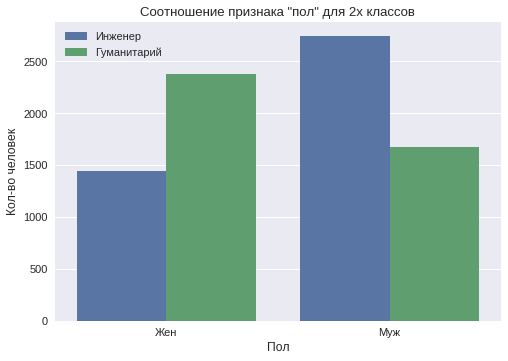

In [67]:
g = sns.countplot(x='sex', hue='is_gum',  data=users_df.drop(index_to_del))
sns.set(font_scale=1.1)

g.set_ylabel('Кол-во человек')
g.set_xlabel('Пол')

plt.xticks(range(2), ('Жен', 'Муж')) 

handles, labels = g.get_axes().get_legend_handles_labels()
g.get_axes().legend(handles, ['Инженер', 'Гуманитарий'], loc='upper left')
plt.title('Соотношение признака "пол" для 2х классов')

## Alcohol

In [69]:
alcohol_df = users_df.dropna(subset=['alcohol'])
alcohol_vc = alcohol_df.is_gum.value_counts()
alcohol_vc

0.0    1526
1.0    1431
Name: is_gum, dtype: int64

In [70]:
delta = alcohol_vc[0] - alcohol_vc[1]
delta

95

In [71]:
index_to_del = np.random.choice(alcohol_df[alcohol_df.is_gum == 0].index, delta, replace=False)
alcohol_df.drop(index_to_del, inplace=True)
alcohol_df.is_gum.value_counts()

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.0    1431
0.0    1431
Name: is_gum, dtype: int64

In [72]:
# замена местами компромисное и нейтральное
alcohol_df.loc[alcohol_df.alcohol == 3, 'alcohol'] = 6
alcohol_df.loc[alcohol_df.alcohol == 4, 'alcohol'] = 3
alcohol_df.loc[alcohol_df.alcohol == 6, 'alcohol'] = 4

/home/digitman/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/home/digitman/miniconda3/lib/python3.6/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


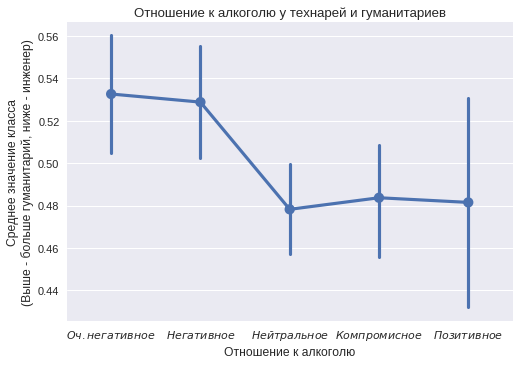

In [73]:
g = sns.pointplot(x="alcohol", y="is_gum", data=alcohol_df, ci=80) #, kind='swarm');

sns.set(font_scale=1.1)

g.set_xlabel('Отношение к алкоголю')
g.set_ylabel('Среднее значение класса\n(Выше - больше гуманитарий, ниже - инженер)')

plt.xticks(range(5), ('$Оч. негативное$', '$Негативное$', '$Нейтральное$', '$Компромисное$', '$Позитивное$')) 

handles, labels = g.get_axes().get_legend_handles_labels()
plt.title('Отношение к алкоголю у технарей и гуманитариев')

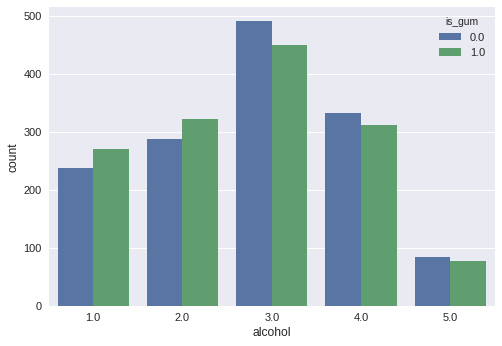

In [76]:
g = sns.countplot(x='alcohol', hue='is_gum',  data=alcohol_df)

## Smoking

In [77]:
smoking_df = users_df.dropna(subset=['smoking'])
smoking_vc = smoking_df.is_gum.value_counts()
smoking_vc

0.0    1609
1.0    1487
Name: is_gum, dtype: int64

In [79]:
delta = smoking_vc[0] - smoking_vc[1]
delta

122

In [80]:
index_to_del = np.random.choice(smoking_df[smoking_df.is_gum == 0].index, delta, replace=False)
smoking_df.drop(index_to_del, inplace=True)
smoking_df.is_gum.value_counts()

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.0    1487
0.0    1487
Name: is_gum, dtype: int64

In [81]:
# замена местами компромисное и нейтральное
smoking_df.loc[smoking_df.smoking == 3, 'smoking'] = 6
smoking_df.loc[smoking_df.smoking == 4, 'smoking'] = 3
smoking_df.loc[smoking_df.smoking == 6, 'smoking'] = 4

/home/digitman/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [82]:
# plt.xkcd()

/home/digitman/miniconda3/lib/python3.6/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


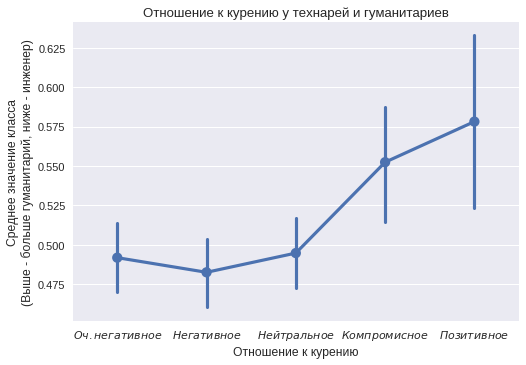

In [83]:
g = sns.pointplot(x="smoking", y="is_gum", data=smoking_df, ci=80) #, kind='swarm');

sns.set(font_scale=1.1)

g.set_xlabel('Отношение к курению')
g.set_ylabel('Среднее значение класса\n(Выше - больше гуманитарий, ниже - инженер)')

plt.xticks(range(5), ('$Оч. негативное$', '$Негативное$', '$Нейтральное$', '$Компромисное$', '$Позитивное$')) 

handles, labels = g.get_axes().get_legend_handles_labels()
plt.title('Отношение к курению у технарей и гуманитариев')

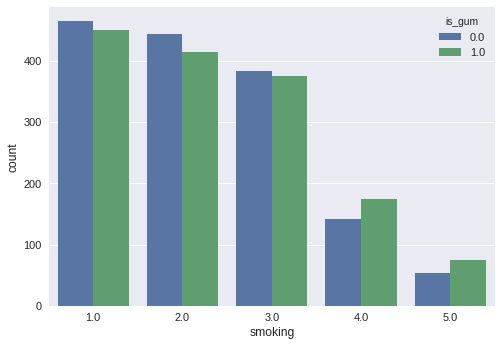

In [84]:
g = sns.countplot(x='smoking', hue='is_gum',  data=smoking_df)

## Political

In [85]:
political_df = users_df.dropna(subset=['political'])
political_vc = political_df.is_gum.value_counts()
political_vc

0.0    1493
1.0    1374
Name: is_gum, dtype: int64

In [86]:
delta = political_vc[0] - political_vc[1]
delta

119

In [87]:
index_to_del = np.random.choice(political_df[political_df.is_gum == 0].index, delta, replace=False)
political_df.drop(index_to_del, inplace=True)
political_df.is_gum.value_counts()

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.0    1374
0.0    1374
Name: is_gum, dtype: int64

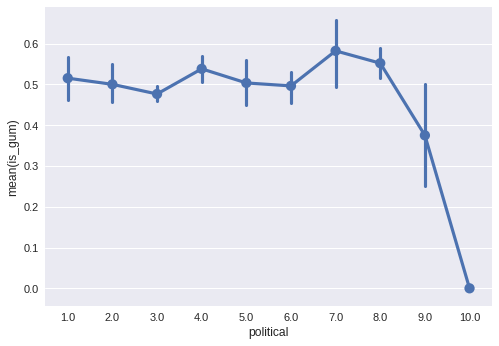

In [88]:
g = sns.pointplot(x="political", y="is_gum", data=political_df, ci=80) #, kind='swarm');

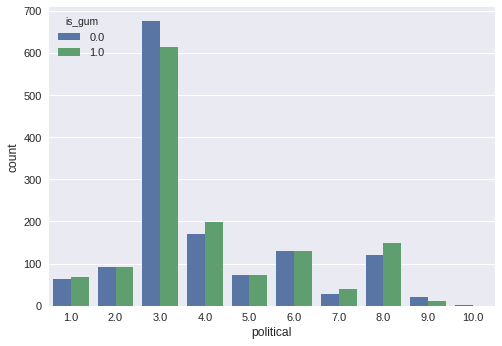

In [89]:
g = sns.countplot(x='political', hue='is_gum',  data=political_df)

## Relation

In [90]:
relation_df = users_df.dropna(subset=['relation'])
relation_vc = relation_df.is_gum.value_counts()
relation_vc

0.0    4281
1.0    4057
Name: is_gum, dtype: int64

In [91]:
delta = relation_vc[0] - relation_vc[1]
delta

224

In [92]:
index_to_del = np.random.choice(relation_df[relation_df.is_gum == 0].index, delta, replace=False)
relation_df.drop(index_to_del, inplace=True)
relation_df.is_gum.value_counts()

1.0    4057
0.0    4057
Name: is_gum, dtype: int64

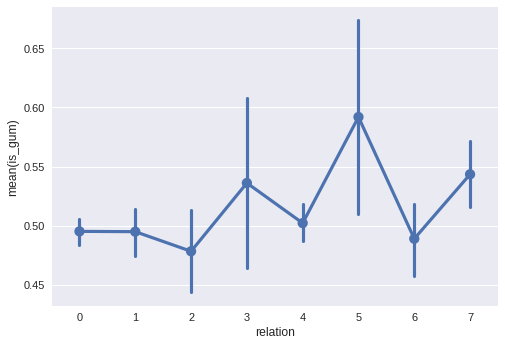

In [94]:
sns.pointplot(x="relation", y="is_gum", data=relation_df, ci=80) #, kind='swarm');

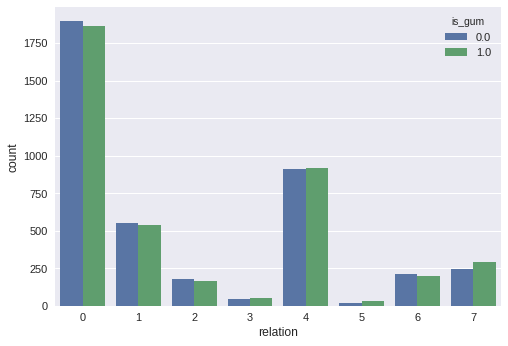

In [95]:
g = sns.countplot(x='relation', hue='is_gum',  data=relation_df)

## Life-main

In [96]:
life_main_df = users_df.dropna(subset=['life_main'])
life_main_vc = life_main_df.is_gum.value_counts()
life_main_vc

1.0    1536
0.0    1476
Name: is_gum, dtype: int64

In [97]:
delta = life_main_vc[1] - life_main_vc[0]
delta

60

In [98]:
index_to_del = np.random.choice(life_main_df[life_main_df.is_gum == 1].index, delta, replace=False)
life_main_df.drop(index_to_del, inplace=True)
life_main_df.is_gum.value_counts()

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.0    1476
0.0    1476
Name: is_gum, dtype: int64

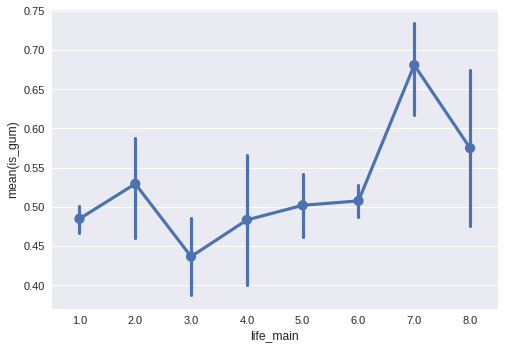

In [100]:
sns.pointplot(x="life_main", y="is_gum", data=life_main_df, ci=80) #, kind='swarm');

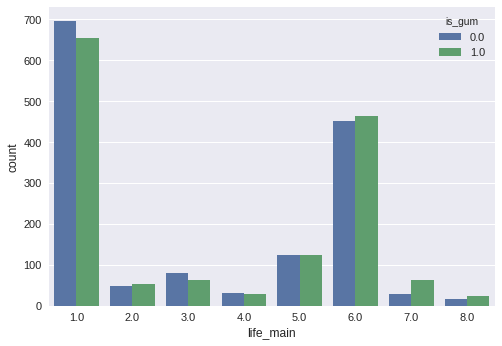

In [101]:
g = sns.countplot(x='life_main', hue='is_gum',  data=life_main_df)

## People-main

In [102]:
people_main_df = users_df.dropna(subset=['people_main'])
people_main_vc = people_main_df.is_gum.value_counts()
people_main_vc

1.0    1557
0.0    1547
Name: is_gum, dtype: int64

In [103]:
delta = people_main_vc[1] - people_main_vc[0]
delta

10

In [104]:
index_to_del = np.random.choice(people_main_df[people_main_df.is_gum == 1].index, delta, replace=False)
people_main_df.drop(index_to_del, inplace=True)
people_main_df.is_gum.value_counts()

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1.0    1547
0.0    1547
Name: is_gum, dtype: int64

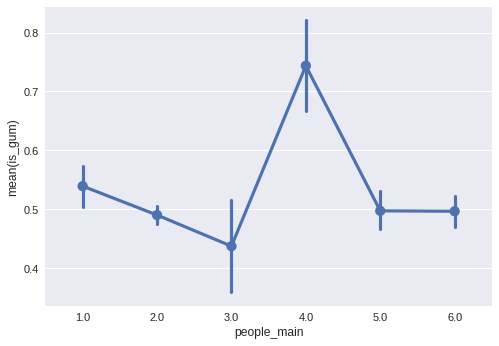

In [106]:
sns.pointplot(x="people_main", y="is_gum", data=people_main_df, ci=80) #, kind='swarm');

In [107]:
people_main_df.people_main.value_counts()

2.0    1646
6.0     612
5.0     390
1.0     343
3.0      64
4.0      39
Name: people_main, dtype: int64

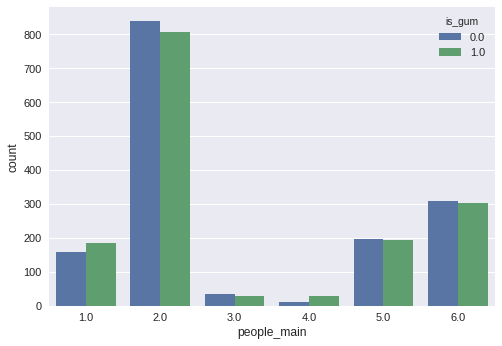

In [108]:
g = sns.countplot(x='people_main', hue='is_gum',  data=people_main_df)

## Month

In [109]:
users_df.bdate = pd.to_datetime(users_df.bdate, errors='coerce')

In [110]:
bdate_df = users_df.dropna(subset=['bdate'])

In [111]:
bdate_vc = bdate_df.is_gum.value_counts()
bdate_vc

0.0    2233
1.0    2066
Name: is_gum, dtype: int64

In [112]:
delta = bdate_vc[0] - bdate_vc[1]
delta

167

In [113]:
index_to_del = np.random.choice(bdate_df[bdate_df.is_gum == 0].index, delta, replace=False)
index_to_del.shape

(167,)

In [114]:
bdate_df.drop(index_to_del, inplace=True)
bdate_df.is_gum.value_counts()

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.0    2066
1.0    2066
Name: is_gum, dtype: int64

In [115]:
bdate_df['bmonth'] = bdate_df.bdate.apply(lambda x: x.month if x else x)

/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


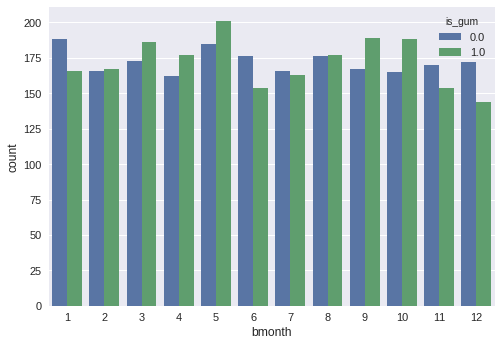

In [116]:
g = sns.countplot(x='bmonth', hue='is_gum',  data=bdate_df)

# Comments

In [117]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969507 entries, 0 to 2969506
Data columns (total 9 columns):
attachments     object
comment_id      int64
date            int64
from_id         int64
likes           int64
owner_id        object
reply_to_cid    object
reply_to_uid    object
text            object
dtypes: int64(4), object(5)
memory usage: 203.9+ MB


In [118]:
comments_merged = comments_df.merge(users_df[['id', 'is_gum', 'sex']], left_on='from_id', right_on='id', how='inner')

In [119]:
(comments_merged.from_id.value_counts() > 5).sum() # was 3053

3135

### Generating hour from comment date

In [120]:
comments_merged['hour'] = comments_merged.date.apply(lambda x: datetime.fromtimestamp(x).hour)

In [121]:
comments_merged.info() # was 193715

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202818 entries, 0 to 202817
Data columns (total 13 columns):
attachments     13650 non-null object
comment_id      202818 non-null int64
date            202818 non-null int64
from_id         202818 non-null int64
likes           202818 non-null int64
owner_id        202818 non-null object
reply_to_cid    0 non-null object
reply_to_uid    0 non-null object
text            202818 non-null object
id              202818 non-null int64
is_gum          202818 non-null float64
sex             202818 non-null int64
hour            202818 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 21.7+ MB


In [122]:
comments_merged.head()

,attachments,comment_id,date,from_id,likes,owner_id,reply_to_cid,reply_to_uid,text,id,is_gum,sex,hour
0,None,3804998,1506163809,170328895,9,-33041211,None,None,А еще сегодня у нас в Советском районе нашлы м...,170328895,1.0,1,13
1,None,3805009,1506164128,170328895,0,-33041211,None,None,"[id231306085|Алиса], не слышала такой информац...",170328895,1.0,1,13
2,None,3805017,1506164353,170328895,0,-33041211,None,None,"Алиса, хорошо бы ,у нас ни от кого такой инфор...",170328895,1.0,1,13
3,None,3805026,1506164822,170328895,1,-33041211,None,None,"[id231306085|Алиса], да я тоже именно это и сл...",170328895,1.0,1,14
4,None,3805030,1506164985,170328895,6,-33041211,None,None,"[id54206198|Игорь], как то уж слишком большое ...",170328895,1.0,1,14


In [123]:
comments_merged.is_gum.value_counts()

0.0    116517
1.0     86301
Name: is_gum, dtype: int64

## Nice plot

In [124]:
comments_merged['Гумманитарий'] = comments_merged.is_gum

In [125]:
comments_merged.Гумманитарий = comments_merged.Гумманитарий.map({0: False, 1: True})

In [126]:
merged_vc = comments_merged.is_gum.value_counts()
merged_vc

0.0    116517
1.0     86301
Name: is_gum, dtype: int64

In [127]:
delta = merged_vc[0] - merged_vc[1]
delta

30216

In [128]:
index_to_del = np.random.choice(comments_merged[comments_merged.is_gum == 0].index, delta, replace=False)

In [129]:
merged_ = comments_merged.drop(index_to_del)
merged_.is_gum.value_counts()

0.0    86301
1.0    86301
Name: is_gum, dtype: int64

In [130]:
%matplotlib inline

/home/digitman/miniconda3/lib/python3.6/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


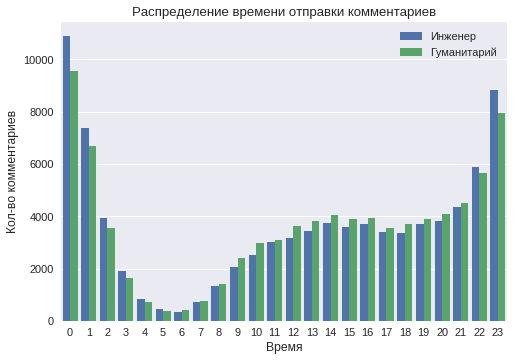

In [131]:
sns.set(font_scale=1.1)
g = sns.countplot(x='hour', hue='Гумманитарий', data=merged_, saturation=0.9)
g.set_ylabel('Кол-во комментариев')
g.set_xlabel('Время')
plt.title('Распределение времени отправки комментариев')

handles, labels = g.get_axes().get_legend_handles_labels()
g.get_axes().legend(handles, ['Инженер', 'Гуманитарий']) #, loc='upper left')

## Another

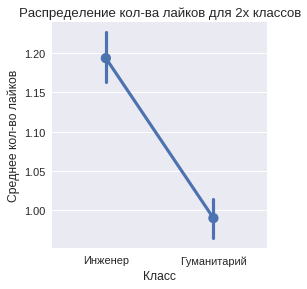

In [132]:
g = sns.factorplot(x='is_gum', y='likes', data=merged_)
sns.set(font_scale=1.1)

g.set_xlabels('Класс')
g.set_ylabels('Среднее кол-во лайков')
plt.title('Распределение кол-ва лайков для 2х классов')

plt.xticks(range(2), ('Инженер', 'Гуманитарий'));

## Saving

In [133]:
index_to_del = comments_merged[comments_merged.text == ''].index
comments_merged.drop(index_to_del, inplace=True)
comments_merged.shape # was 185612

(193539, 14)

In [134]:
comments_merged[['from_id', 'text', 'is_gum', 'hour', 'likes', 'sex']].to_csv('data/comments_vrn.csv.gz',
                                                                       index=False, compression='gzip')